# PyLec 6 - Word2Vec using gensim package

## Word2Vec

Word2Vec은 Tomas Mikolov에 의해 처음 발명된 자연언어처리(NLP) 알고리즘입니다. 이 알고리즘을 한마디로 설명하면

> 문장 내의 중심단어(center 또는 context word)와 주변단어(outside 또는 surrounding word)의 발생 빈도를 이용하여 단어를 벡터화한다.

입니다. 이 알고리즘을 이해하기 위해서 우리는 몇 가지 개념을 미리 알아야 합니다.

### CBOW와 Skip-gram

CBOW(Continuous Bag-Of-Words)은 어떤 단어의 뜻을 파악하기 위해서는 그 단어가 들어있는 문장 또는 글(context)에서 사용된 단어들, 즉 단어들의 집합(bag-of-words)를 봐야한다는 개념입니다. 예를 들어

> "김아무개는 똑똑하고, 성실하다."

라는 문장에 포함된 "김아무개", "똑똑하다(똑똑하고)", "성실하다"라는 단어는 모두 "김아무개"를 설명하는 단어라 할 수 있습니다. 즉, 어떤 중심 단어를 이해하려면 그 단어가 포함된 문장이나 단락에 쓰인 단어를 분석하여 의미를 찾자는 것이 CBOW입니다.

반면에 skip-gram은 이와는 반대의 개념입니다. 문장이나 단락 속에 쓰인 어떤 단어는 그 주변 단어의 의미를 설명한다고 생각하는 것입니다. 예를 들어

> "나는 장례식에 다녀왔다. 그곳에는 슬퍼하며 우는 사람들이 많았다."

라는 문장에서 "장례식", "슬프다(슬퍼하며)", "울다(우는)", "사람(들)"라는 단어의 의미를 분석하다고 해 봅시다. "장례식"은 "슬프다", "울다", "사람"이라는 단어를 설명한다고 볼 수 있습니다. 마찬가지로 "슬프다"는 "장례식", "울다", "사람"이라는 단어를 설명하는 단어라 생각할 수 있습니다. 

CBOW와 skip-gram의 큰 차이점은 속도와 정확성입니다. CBOW는 각 중심단어를 선택할 때마다 그 주변 단어에 의해 의미가 결정됩니다. 만약 전체 글에서 100번 등장하는 단어의 의미는 100번의 학습을 통해 의미가 결정됩니다. (여기서 의미가 결정된다는 것을 결국 그 단어를 표현하는 벡터를 결정한다는 뜻입니다.) 이에 반해 skip-gram은 중심 단어를 선택할 때마다 주변 단어의 의미가 새롭게 학습됩니다. 다시 말해 글 속에 10만개의 단어(중복되는 것을 모두 세었다고 할 때)가 있고, 앞뒤로 10개씩의 주변 단어의 의미를 학습시킨다면 100만번 학습이 이루어 집니다. 

중요한 것은 각 단어마다 학습되는 횟수가 skip-gram이 CBOW보다 훨씬 많다는 것입니다. 예를 들어 서로 다른 단어가 총 1000개가 있는 10만개의 단어로 이루어진 글에서, 각 단어가 정확히 (예를 들자면 그렇습니다) 1000번 나온다고 가정해 봅시다. CBOW에 의하면, 총 학습 횟수는

1000(서로 다른 단어의 갯수) x 1000(등장횟수) = 10만

입니다. 반면에 skip-gram을 이용해서 각 중심 단어 마다 주변의 10개 단어를 학습시킨다고 했을때

10만(총 단어의 갯수) x 10개 = 100만

이 됩니다. 이 학습량의 차이로 인해 일반적으로 skip-gram이 CBOW보다 느리지만, 정확한 결과를 줍니다. 우리가 이용하는 `gensim` 패키지는 skip-gram을 이용한 Word2Vec 알고리즘을 구현한 것입니다.

## Word2Vec의 신경망 모형

Word2Vec은 소스코드와 알고리즘이 모두 공개되어 있습니다. 저는 [이곳](https://ratsgo.github.io/from%20frequency%20to%20semantics/2017/03/30/word2vec/)을 참고하여 Word2Vec에 대한 설명을 적었습니다. 

Word2Vec을 구성하는 신경망 모형은 아래와 같이 은닉층이 하나인 간단한 구조입니다.

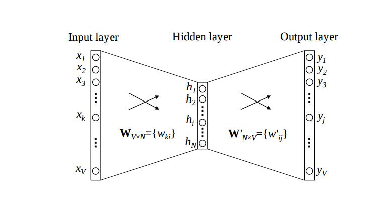

In [8]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

img = imread('../data/word2vecnn.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()

Input layer와 output layer의 노드의 갯수는 전체 (서로 다른) 단어의 수 입니다. 은닉층의 노드의 갯수는 자유롭게 정할 수 있습니다. Weight matrix가 두 개 필요한데, 이를 $W,W'$이라 합시다. 만약 단어의 수가 $N$개이고, 은닉층의 노드가 $n$개 있다면 $W$는 $N\times n$, $W'$는 $n\times N$행렬입니다.

Input 노드는 각각 단어를 뜻합니다. 예를 들어 "강아지", "개미" 등으로 시작해서 "한강"으로 끝나는 단어들로 이루어진 글이 있다면, "강아지"라는 단어는 $(1,0,\cdots,0)$으로, "개미"는 $(0,1,\cdots,0)$으로, 그리고 "한강"은 $(0,0,\cdots,1)$로 표현됩니다. 

Hidden 노드는 기계 학습을 통해 얻어진 단어를 구성하는 요소들을 나타내는 양입니다. 우리는 정확히 각 노드가 무엇을 뜻하는지 모릅니다. (이게 기계 학습의 신비이자, 매력입니다.)

Output 노드도 input 노드와 마찬가지로 각 단어를 의미합니다. 그런데 의문이 한 가지 들 수 있습니다. 손글씨 학습 (MNIST 데이터를 이용한) 에서는 결과층에서 가장 큰 값을 가진 (가장 1에 가까운) 노드가 예측값, 즉 인식한 숫자를 가리키는데, 이 신경망에서는 결과층 노드로부터 무엇을 예측하는 것인가요?

## Word2Vec의 학습과 결과

결론부터 말씀드리면, Word2Vec은 기계학습을 통해 결과층으로 부터 예측값을 얻으려는 것이 아닙니다. 학습이 끝난 뒤, 모형의 가중치행렬 $W$,$W'$가 결과입니다. 행렬 $W$의 각 행은 $n$차원 벡터이고, $i$번째 행 벡터가 $i$번째 단어의 벡터(word-vector)가 됩니다. 비슷하게 행렬 $W'$의 각 열은 $n$차원 벡터이고, $j$번째 열 벡터가 $j$번째 단어의 벡터가 됩니다. 주목할 점은 $i$번째 단어를 표현하는 벡터는 $W$의 $i$번째 행일 수도 있고, 행렬 $W'$의 $i$번째 열 일수도 있다는 것입니다. 다시 말해 $W,W'$는 모두 단어 벡터를 가리킵니다.

$$W = \begin{bmatrix} v_1 \\ v_2 \\ \vdots \\ v_N \end{bmatrix},\quad W' = \begin{bmatrix}u_1 & u_2 & \cdots & u_N\end{bmatrix}$$

중심단어 c가 발생했을 경우, 주변단어 o가 정해진 크기의 범위(window)내에 존재할 확률을 아래와 같이 정의합니다.

$$P(o|c) = \frac{\exp(v_cu_o)}{\sum_{w=1}^N\exp(v_cu_w)}$$

여기서 $v_cu_o, v_cu_w$는 각각 행 벡터, 열 벡터의 곱, 즉, 두 벡터의 내적입니다. skip-gram을 이용한다고 할 때, Word2Vec에서는 아래의 엔트로피를 최소화하는 것으로 학습을 진행합니다.

$$J = -\frac{1}{N}\sum_c\sum_{i=-m,\cdots,-1,1,\cdots,m}\log P(c+i|c)$$

여기서 $m$은 윈도우의 크기입니다. 즉 중심단어 c의 앞뒤로 $m$개의 주변단어의 조건부 발생확률을 최대한 1이 되도록 만드는 것이 목표입니다. 중요한 것은 엔트로피 $J$는 행렬 $W,W'$의 함수이고, 다시 말해, 벡터 $v_1,v_2,\cdots,v_N,u_1,u_2,\cdots,u_N$로 결정된다는 점입니다. 즉, 매 학습마다 벡터 $v_i,u_j$가 $J$를 최소화하는 방향으로 업데이트 됩니다. 

## Gensim 패키지 예제

`Word2Vec`을 쉽게 패키지로 구성한 `gensim`을 이용해 봅시다. 이 패키지를 이용하면 `Word2Vec`을 이용한 NLP가 대단히 쉬워집니다.

In [3]:
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec

path = get_tmpfile("word2vec.model")

model = Word2Vec(common_texts, size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")

In [4]:
model = Word2Vec.load("word2vec.model")
model.train([["hello", "world"]], total_examples=1, epochs=1)

(0, 2)

In [5]:
vector = model.wv['computer']

In [6]:
print(common_texts)

[['human', 'interface', 'computer'], ['survey', 'user', 'computer', 'system', 'response', 'time'], ['eps', 'user', 'interface', 'system'], ['system', 'human', 'system', 'eps'], ['user', 'response', 'time'], ['trees'], ['graph', 'trees'], ['graph', 'minors', 'trees'], ['graph', 'minors', 'survey']]


## Word2Vec을 이용한 단어 분석 예제

Word2Vec 알고리즘을 이용하여 Elizabeth Bennet의 소설 "Pride and Prejudice"에 사용된 단어를 분석해 봅시다. `gensim`패키지에는 문장의 단어를 쉽게 tokenize해 주는 함수가 있습니다. 마침표, 쉼표와 같은 문장 부호를 없애고, 단어만 추출해서 리스트로 반환하는 함수입니다. (한글 문장에도 사용할 수 있으나, 한글 단어는 영어 단어 만큼 분석하기가 쉽지 않습니다.)

In [33]:
import gensim.utils

with open("../data/pride-and-prejudice.txt") as file:
    text = []
    line = file.readline()
    while line:
        text.append(gensim.utils.simple_preprocess(line))
        line = file.readline()

model = Word2Vec(text, size=10, window=5, min_count=1, workers=4)
model.train(text, total_examples=len(text), epochs=10)

(873607, 1206760)

In [23]:
print(model.wv['girl'])

[ 1.433331   -0.55276644 -0.26824057 -0.70237684 -1.5833776  -0.45125788
 -0.7469714  -1.4926202  -0.29043862 -0.47003198]


In [24]:
model.wv.most_similar(positive='girl')

[('afraid', 0.971770167350769),
 ('pray', 0.9713099002838135),
 ('ma', 0.9711407423019409),
 ('affect', 0.969366192817688),
 ('guess', 0.9663979411125183),
 ('luck', 0.9661697149276733),
 ('glad', 0.9655526876449585),
 ('don', 0.9639321565628052),
 ('ugly', 0.9636090397834778),
 ('kind', 0.9617618918418884)]

In [28]:
with open("../data/emma.txt") as file:
    text = []
    line = file.readline()
    while line:
        text.append(gensim.utils.simple_preprocess(line))
        line = file.readline()
        
model.train(text, total_examples=len(text), epochs=100)

(10577075, 15724300)

In [29]:
print(model.wv['girl'])

[-1.0697161  -1.6625813  -3.4803298  -3.6497455  -4.2666283   0.01231452
  1.4114226   0.9766606   1.0211122  -0.9306446 ]


In [30]:
model.wv.most_similar(positive='girl')

[('manners', 0.8951220512390137),
 ('lady', 0.8853644132614136),
 ('highly', 0.8635010719299316),
 ('creature', 0.863320529460907),
 ('man', 0.8549402952194214),
 ('neighbours', 0.8499704599380493),
 ('difference', 0.8434948921203613),
 ('superior', 0.8180605173110962),
 ('family', 0.8164973855018616),
 ('extracts', 0.8007155060768127)]

In [21]:
model.wv.similarity(w1='girl', w2='boy')

0.6225797750749156